# SAC

In [37]:
import math
import random
import sys

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from tensorboardX import SummaryWriter

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

# Networks

In [72]:
def gaussian_likelihood(x, mu, log_std, eps=1e-8):
    #-0.5 * (((x-mu)/(tf.exp(log_std)+EPS))**2 + 2*log_std + np.log(2*np.pi))
#     return Normal(mu, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
    return torch.sum(-0.5  * ((x-mu) / log_std.exp() + eps)**2 + 2 * log_std + np.log(2*np.pi))

In [39]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=[400,300], init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim[0])
        self.linear2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.linear3 = nn.Linear(hidden_dim[1], 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [40]:
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=[400,300], init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size[0])
        self.linear2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear3 = nn.Linear(hidden_size[1], 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=[400,300], init_w=3e-3, log_std_min=-20, log_std_max=2, epsilon=1e-6):
        super(PolicyNetwork, self).__init__()
        
        self.epsilon = epsilon
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size[0])
        self.linear2 = nn.Linear(hidden_size[0], hidden_size[1])
        
        self.mean_linear = nn.Linear(hidden_size[1], num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size[1], num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)

        return mean, log_std
        
#         std = log_std.exp()
#         z = mean + std * Normal(0,1).sample().requires_grad_()
#         action = torch.tanh(z)
        
#         logp_pi = Normal(mean, std).log_prob(z) - torch.log(1 - action * action + self.epsilon)
#         logp_pi = logp_pi.sum(dim=1, keepdim=True)
        
#         # this assumes action range is scaled to [0,1]
#         action = torch.tanh(mean + std * Normal(0, 1).sample())
#         logp_pi = gaussian_likelihood(action, log_std)
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z = mean + std * normal.sample().requires_grad_()
        action = torch.tanh(z)
        logp_pi = Normal(mean, std).log_prob(z) - torch.log(1 - action * action + self.epsilon)
        logp_pi = logp_pi.sum(dim=1, keepdim=True)
        
#         z      = normal.sample()
#         action = torch.tanh(mean+ std*z.to(device))
#         log_prob = gaussian_likelihood(action, mean, log_std)#Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        
        return action, logp_pi, mean, log_std
        
    
    def get_action(self, state, deterministic=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()

        normal = Normal(0, 1)
        z = mean + std * normal.sample().requires_grad_()
        action = torch.tanh(mean) if deterministic else torch.tanh(z)
        
        action  = action.cpu() #.detach().cpu().numpy()
        return action[0]

# Memory

In [114]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [115]:

class NormalizedActions(gym.ActionWrapper):
    def _action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

In [116]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [117]:
def loss_function(value, target):
    """ Carries out a variation of mean squared error

        Args:
            value: current prediciton value
            target: target value

        Returns:
            MSE of the predicted value
    """
    return 0.5 * torch.mean((target.detach() - value)**2)

# Agent

In [118]:
class SAC(object):
    
    def __init__(self, state_dim, action_dim,env):
        
        self.action_dim = action_dim
        self.state_dim  = state_dim
        self.hidden_dim = [400,300]

        self.value_net        = ValueNetwork(self.state_dim, self.hidden_dim).to(device)
        self.target_value_net = ValueNetwork(self.state_dim, self.hidden_dim).to(device)

        self.soft_q_net1 = SoftQNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.soft_q_net2 = SoftQNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)

        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(param.data)


        self.value_criterion  = nn.MSELoss()
        self.soft_q_criterion1 = nn.MSELoss()
        self.soft_q_criterion2 = nn.MSELoss()

        self.value_lr  = 3e-4
        self.soft_q_lr = 3e-4
        self.policy_lr = 3e-4

        self.value_optimizer  = optim.Adam(self.value_net.parameters(), lr=self.value_lr)
        self.soft_q_optimizer1 = optim.Adam(self.soft_q_net1.parameters(), lr=self.soft_q_lr)
        self.soft_q_optimizer2 = optim.Adam(self.soft_q_net2.parameters(), lr=self.soft_q_lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=self.policy_lr)


        replay_buffer_size = 1000000
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
    
    def select_action(self,state):
        return self.policy_net.get_action(state).detach()
        
        
    def update(self, batch_size,gamma=0.99,soft_tau=1e-2,):
        
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)

        state      = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        action     = torch.FloatTensor(action).to(device)
        reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
        done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

        predicted_q_value1 = self.soft_q_net1(state, action)
        predicted_q_value2 = self.soft_q_net2(state, action)
        predicted_value    = self.value_net(state)
        new_action, log_prob, mean, log_std = self.policy_net.evaluate(state)



    # Training Q Function
        target_value = self.target_value_net(next_state)
        target_q_value = reward + (1 - done) * gamma * target_value
#         q_value_loss1 = self.soft_q_criterion1(predicted_q_value1, target_q_value.detach())
#         q_value_loss2 = self.soft_q_criterion2(predicted_q_value2, target_q_value.detach())
        q_value_loss1 = 0.5 * torch.mean((target_q_value.detach() - predicted_q_value1)**2)
        q_value_loss2 = 0.5 * torch.mean((target_q_value.detach() - predicted_q_value2)**2)


        self.soft_q_optimizer1.zero_grad()
        q_value_loss1.backward()
        self.soft_q_optimizer1.step()
        self.soft_q_optimizer2.zero_grad()
        q_value_loss2.backward()
        self.soft_q_optimizer2.step()  
        
    # Training Value Function
        predicted_new_q_value = torch.min(self.soft_q_net1(state, new_action),self.soft_q_net2(state, new_action))
        target_value_func = predicted_new_q_value - log_prob * 0.2 #alpha
#         value_loss = self.value_criterion(predicted_value, target_value_func.detach())
        value_loss = 0.5 * torch.mean((target_value_func.detach() - predicted_value)**2)


        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
    # Training Policy Function
#         policy_loss = (log_prob - predicted_new_q_value).mean()
        policy_loss = torch.mean(0.2 * log_prob - predicted_new_q_value)

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()


        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
        
    

# Runner

In [119]:
class Runner():
    """Carries out the environment steps and adds experiences to memory"""
    
    def __init__(self, env, agent):
        
        self.env = env
        self.agent = agent
#         self.replay_buffer = replay_buffer
        self.obs = env.reset()
        self.done = False
        
    def next_step(self, episode_timesteps, noise=0.1):
        
        action = self.agent.select_action(self.obs)
        

        # Perform action
        # TODO: Clean up get action 
        new_obs, reward, done, _ = self.env.step(action.numpy()) 
        done_bool = 0 if episode_timesteps + 1 == 200 else float(done)
    
        # Store data in replay buffer
#         replay_buffer.add((self.obs, new_obs, action, reward, done_bool))
        self.agent.replay_buffer.push(self.obs, action, reward, new_obs, done_bool)
        
        self.obs = new_obs
        
        if done:
            self.obs = self.env.reset()
            done = False
            
            return reward, True
        
        return reward, done

# Observe

In [120]:
def observe(env, agent, observation_steps):
    """run episodes while taking random actions and filling replay_buffer
    
        Args:
            env (env): gym environment
            replay_buffer(ReplayBuffer): buffer to store experience replay
            observation_steps (int): how many steps to observe for
    
    """
    
    time_steps = 0
    obs = env.reset()
    done = False

    while time_steps < observation_steps:
        action = env.action_space.sample()
        new_obs, reward, done, _ = env.step(action)

        agent.replay_buffer.push(obs, action, reward, new_obs, done)

        obs = new_obs
        time_steps += 1

        if done:
            obs = env.reset()
            done = False

        print("\rPopulating Buffer {}/{}.".format(time_steps, observation_steps), end="")
        sys.stdout.flush()

# Train

In [121]:
def train(agent, test_env):
    """Train the agent for exploration steps
    
        Args:
            agent (Agent): agent to use
            env (environment): gym environment
            writer (SummaryWriter): tensorboard writer
            exploration (int): how many training steps to run
    
    """

    total_timesteps = 0
    timesteps_since_eval = 0
    episode_num = 0
    episode_reward = 0
    episode_timesteps = 0
    done = False 
    obs = env.reset()
    evaluations = []
    rewards = []
    best_avg = -2000
    
    writer = SummaryWriter(comment="-TD3_Baseline_HalfCheetah")
    
    while total_timesteps < EXPLORATION:
    
        if done: 

            if total_timesteps != 0: 
                rewards.append(episode_reward)
                
                if total_timesteps % 1000 == 0:
                    plot(len(rewards), rewards)
                
                avg_reward = np.mean(rewards[-100:])
                
                writer.add_scalar("avg_reward", avg_reward, total_timesteps)
                writer.add_scalar("reward_step", reward, total_timesteps)
                writer.add_scalar("episode_reward", episode_reward, total_timesteps)
                
                print("\rTotal T: {:d} Episode Num: {:d} Reward: {:f} Avg Reward: {:f}".format(
                    total_timesteps, episode_num, episode_reward, avg_reward), end="")
                sys.stdout.flush()


                if avg_reward >= REWARD_THRESH:
                    break

#                 agent.update(replay_buffer, episode_timesteps, BATCH_SIZE, GAMMA, TAU, NOISE, NOISE_CLIP, POLICY_FREQUENCY)
#                 agent.update(128)

                episode_reward = 0
                episode_timesteps = 0
                episode_num += 1 

        reward, done = runner.next_step(episode_timesteps)
        episode_reward += reward

        episode_timesteps += 1
        total_timesteps += 1
        timesteps_since_eval += 1
        
        agent.update(100)
        
        

# Config

In [122]:
ENV = "Pendulum-v0"
SEED = 0
OBSERVATION = 10000
EXPLORATION = 40000
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
NOISE = 0.2
NOISE_CLIP = 0.5
EXPLORE_NOISE = 0.1
POLICY_FREQUENCY = 2
EVAL_FREQUENCY = 5000
REWARD_THRESH = -100

# Main

In [123]:
env = NormalizedActions(gym.make(ENV))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds
env.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

agent = SAC(state_dim, action_dim, env)

# replay_buffer = ReplayBuffer()

runner = Runner(env, agent)

total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True

In [124]:
# Populate replay buffer
observe(env, agent, OBSERVATION)

Populating Buffer 9780/10000.

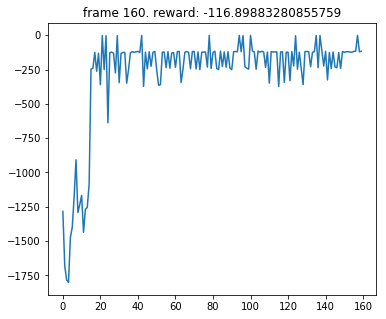

Total T: 32000 Episode Num: 159 Reward: -116.898833 Avg Reward: -160.321762

In [ ]:
# Train agent
train(agent, env)